In [1]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

Mounted at /content/drive


In [2]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .config('spark.driver.memory', '4g')\
         .config('spark.executor.memory', '4g')\
         .config('spark.python.worker.memory', '2g')\
         .getOrCreate()
spark

from pyspark import SparkContext, SparkConf
import sys
import json
#from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.types import *
#from pyspark.sql.functions import *
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate()

In [3]:
# list of 182 users
num_enabled_users = 182
user_list = list(range(num_enabled_users))
if (128 in user_list):
  user_list.remove(128)

# define schema
schema = StructType([
    StructField("Lat", StringType(), True), StructField("Long", StringType(), True), StructField("Zero", StringType(), True), StructField("Alt", StringType(), True), StructField("DayCount", StringType(), True), StructField("Date", StringType(), True), StructField("Time", StringType(), True), StructField("UserId", StringType(), True)
])

# empty combined df
df_combine = spark.createDataFrame([], schema)


for ii in range(len(user_list)):
  folder_name = "{0:0=3d}".format(user_list[ii])
  data_user = "/content/drive/MyDrive/DataEngAtScaleProject/GeolifeTrajectories/Data/"+folder_name+"/Trajectory/*.plt"
  #data_user = "/content/drive/MyDrive/DataEngAtScaleProject/GeolifeTrajectories/Data/000/Trajectory/20081023025304.plt"
  #data000 = "/content/drive/MyDrive/DataEngAtScaleProject/GeolifeTrajectories/Data/000/Trajectory/20081023025304.plt"

  # read as rdd
  read_user = sc.textFile(data_user)

  # remove header lines and split the values
  rdd_user = read_user.filter(lambda x: len(x)>40).map(lambda l :  l.split(","))

  # convert rdd to dataframe
  df_user = spark.createDataFrame(rdd_user).toDF("Lat","Long","Zero","Alt","DayCount","Date","Time").withColumn("UserId",F.lit(folder_name)).cache()
  df_combine = df_combine.union(df_user).cache()

df_combine = df_combine.select(F.col("Lat").cast(DoubleType()).alias("Lat"), F.col("Long").cast(DoubleType()).alias("Long"), F.col("Alt").cast(IntegerType()).alias("Alt"), F.col("DayCount").cast(DoubleType()).alias("DayCount"), F.col("Date").cast(DateType()).alias("Date"), "Time", "UserId").cache()

print(df_combine.take(5))
#print(df_combine.count())

[Row(Lat=40.008312, Long=116.320953, Alt=491, DayCount=39765.157037037, Date=datetime.date(2008, 11, 13), Time='03:46:08', UserId='000'), Row(Lat=40.00843, Long=116.321055, Alt=492, DayCount=39765.1570949074, Date=datetime.date(2008, 11, 13), Time='03:46:13', UserId='000'), Row(Lat=40.00849, Long=116.321025, Alt=491, DayCount=39765.1571527778, Date=datetime.date(2008, 11, 13), Time='03:46:18', UserId='000'), Row(Lat=40.008486, Long=116.320962, Alt=491, DayCount=39765.1572106481, Date=datetime.date(2008, 11, 13), Time='03:46:23', UserId='000'), Row(Lat=40.008446, Long=116.320811, Alt=491, DayCount=39765.1572685185, Date=datetime.date(2008, 11, 13), Time='03:46:28', UserId='000')]


In [ ]:
AggregateByDay = df_combine.withColumn("Coord",F.concat_ws(",",("Lat"),("Long"))).select("Coord","Date","UserId").groupBy("Date","UserId").agg(F.first("Coord").alias("Coord")).cache()

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

def GetCityName(Coord):
  location = geolocator.reverse(Coord, language='en')
  address = location.raw['address']
  city = address.get('city', '')
  return city

GetCityName_UDF = F.udf(GetCityName, StringType())

In [ ]:
CityUserDate = AggregateByDay.withColumn("CityName",GetCityName_UDF(F.col("Coord"))).select("CityName","UserId","Date").cache()

In [ ]:
CityList = CityUserDate.select("CityName").distinct().collect()

In [ ]:
CityListFile = open("/content/drive/MyDrive/DataEngAtScaleProject/CityListOutputLog.txt", "w")
for row in CityList:
  CityListFile.writelines(row["CityName"] + ",")

CityListFile.writelines('\n')


In [ ]:
CityUser = CityUserDate.groupBy("UserId","CityName").count().groupBy("UserId").agg(F.max(F.struct(F.col("count"),F.col("CityName"))).alias("max")).select(F.col("UserId"), F.col("max.CityName")).cache()
CityUserSorted = CityUser.withColumn("UserNo",CityUser["UserId"].cast(IntegerType())).drop("UserId").sort("UserNo").collect()

In [ ]:
AggregateByMinutes = df_combine.select("Lat","Long","Date","UserId",F.concat_ws(":",F.split("Time",":").getItem(0),F.split(F.split("Time",":").getItem(1),'').getItem(0)).alias("Minutes")).groupBy("Date","Minutes","UserId").agg(F.first("Lat").alias("Lat"),F.first("Long").alias("Long")).cache()

In [ ]:
AggregateByDay.printSchema()

root
 |-- Date: date (nullable = true)
 |-- UserId: string (nullable = true)
 |-- Coord: string (nullable = true)



In [ ]:
S = AggregateByDay.select("Date","UserId").groupBy("UserId").agg(F.max("Date"),F.min("Date"))
S.show(182)

In [ ]:
S.toPandas().to_csv("/content/drive/MyDrive/DataEngAtScaleProject/DataDateRange.txt")

In [ ]:
S.sort("min(Date)").show(182)

In [ ]:


Per10MinData_user = {}
user_list = list(range(num_enabled_users))
for ii in range(len(user_list)):
  user_name = "{0:0=3d}".format(user_list[ii])
  Per10MinData_user[user_name] = AggregateByMinutes.where(F.col("UserId")==user_name).cache()

SeparationTable = {}
for ii in range(len(user_list)):
  for jj in range(ii+1,len(user_list)):
    user_name1 = "{0:0=3d}".format(user_list[ii])
    user_name2 = "{0:0=3d}".format(user_list[jj])
    if CityUserSorted[ii][0] == CityUserSorted[jj][0]:
      df1 = Per10MinData_user[user_name1].withColumnRenamed("Lat","Lat1").withColumnRenamed("Long","Long1")
      df2 = Per10MinData_user[user_name2].withColumnRenamed("Lat","Lat2").withColumnRenamed("Long","Long2")
      SeparationTable[(ii,jj)] = df1.join(df2,["Date","Minutes"]).withColumn("AbsDiff",F.abs(F.col("Lat1")-F.col("Lat2"))+F.abs(F.col("Long1")-F.col("Long2"))).select("AbsDiff").agg(F.avg("AbsDiff").alias("MeanSeparation")).collect()[0][0]

ClosestUsers = min(SeparationTable, key=SeparationTable.get)

minSeparationFile = open("/content/drive/MyDrive/DataEngAtScaleProject/minSeparationOutputLog.txt", "a")
minSeparationFile.writelines(str(ClosestUsers))
minSeparationFile.writelines('\n')

In [ ]:
print(CityUserSorted)

[Row(CityName='Haidian District', UserNo=0), Row(CityName='Haidian District', UserNo=1), Row(CityName='Xicheng District', UserNo=2), Row(CityName='Haidian District', UserNo=3), Row(CityName='Haidian District', UserNo=4), Row(CityName='Haidian District', UserNo=5), Row(CityName='Haidian District', UserNo=6), Row(CityName='Haidian District', UserNo=7), Row(CityName='Haidian District', UserNo=8), Row(CityName='Haidian District', UserNo=9), Row(CityName='Haidian District', UserNo=10), Row(CityName='Haidian District', UserNo=11), Row(CityName='Haidian District', UserNo=12), Row(CityName='Haidian District', UserNo=13), Row(CityName='Haidian District', UserNo=14), Row(CityName='Haidian District', UserNo=15), Row(CityName='Haidian District', UserNo=16), Row(CityName='Haidian District', UserNo=17), Row(CityName='Dongcheng District', UserNo=18), Row(CityName='Dongcheng District', UserNo=19), Row(CityName='Haidian District', UserNo=20), Row(CityName='', UserNo=21), Row(CityName='Haidian District'

In [ ]:
import geopy.distance

print(geopy.distance.vincenty((31.843897,117.272147),(31.843291,117.266964)))


0.49516801953343176 km


Beijing sightseeing tour

In [ ]:
from pyspark.sql.functions import *

df_30min = df_combine.filter((df_combine.Time.substr(4, 5).contains("00:00") | df_combine.Time.substr(4, 5).contains("30:00"))).cache()
#df_combine.Date.contains("2010") &
#df_30min = df_combine
#print(df_30min.count())

withLessPreciseLatlong = df_30min.withColumn("Lat_3", df_30min.Lat.cast(DecimalType(scale=3))).withColumn("Long_3", df_30min.Long.cast(DecimalType(scale=3))).cache()
print(withLessPreciseLatlong.take(5))

latLongFreq = withLessPreciseLatlong.select("Long_3", "Lat_3", "Date", "UserId").groupBy("Long_3", "Lat_3").agg(count(withLessPreciseLatlong.Date).alias("freq"), countDistinct(withLessPreciseLatlong.UserId).alias("userCount")).cache()
latLongFreqFiltered = latLongFreq.filter((latLongFreq.userCount >= 3) & (latLongFreq.freq < 30)).orderBy("userCount", "freq", ascending=False).cache()

collected = latLongFreqFiltered.select("Long_3", "Lat_3").collect()
long_lats = [(row.Long_3, row.Lat_3) for row in collected]

print(latLongFreqFiltered.take(30))
print(latLongFreq.filter(latLongFreq.userCount >= 3).orderBy("freq", ascending=False).take(100))
print(long_lats)

#print(latLongFreq.count())



[Row(Lat=40.004432, Long=116.321243, Alt=300, DayCount=39794.1875, Date=datetime.date(2008, 12, 12), Time='04:30:00', UserId='000', Lat_3=Decimal('40.004'), Long_3=Decimal('116.321')), Row(Lat=40.00737, Long=116.319546, Alt=155, DayCount=39766.6875, Date=datetime.date(2008, 11, 14), Time='16:30:00', UserId='000', Lat_3=Decimal('40.007'), Long_3=Decimal('116.320')), Row(Lat=40.033158, Long=116.575582, Alt=77, DayCount=39909.1458333333, Date=datetime.date(2009, 4, 6), Time='03:30:00', UserId='000', Lat_3=Decimal('40.033'), Long_3=Decimal('116.576')), Row(Lat=40.080045, Long=116.588057, Alt=30, DayCount=39909.1875, Date=datetime.date(2009, 4, 6), Time='04:30:00', UserId='000', Lat_3=Decimal('40.080'), Long_3=Decimal('116.588')), Row(Lat=39.971705, Long=116.462737, Alt=152, DayCount=39909.2083333333, Date=datetime.date(2009, 4, 6), Time='05:00:00', UserId='000', Lat_3=Decimal('39.972'), Long_3=Decimal('116.463'))]
[Row(Long_3=Decimal('116.332'), Lat_3=Decimal('39.975'), freq=27, userCount=

In [ ]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

!pip install haversine


[(Decimal('116.241'), Decimal('39.926')), (Decimal('116.269'), Decimal('39.929')), (Decimal('116.269'), Decimal('39.935')), (Decimal('116.301'), Decimal('39.987')), (Decimal('116.301'), Decimal('40.050')), (Decimal('116.302'), Decimal('39.970')), (Decimal('116.303'), Decimal('39.974')), (Decimal('116.304'), Decimal('39.927')), (Decimal('116.304'), Decimal('39.930')), (Decimal('116.304'), Decimal('39.971')), (Decimal('116.304'), Decimal('39.978')), (Decimal('116.304'), Decimal('39.984')), (Decimal('116.305'), Decimal('39.975')), (Decimal('116.305'), Decimal('39.976')), (Decimal('116.305'), Decimal('39.977')), (Decimal('116.305'), Decimal('39.984')), (Decimal('116.305'), Decimal('39.988')), (Decimal('116.306'), Decimal('39.984')), (Decimal('116.307'), Decimal('39.982')), (Decimal('116.307'), Decimal('39.984')), (Decimal('116.309'), Decimal('39.984')), (Decimal('116.309'), Decimal('39.995')), (Decimal('116.309'), Decimal('39.996')), (Decimal('116.309'), Decimal('39.999')), (Decimal('116.3

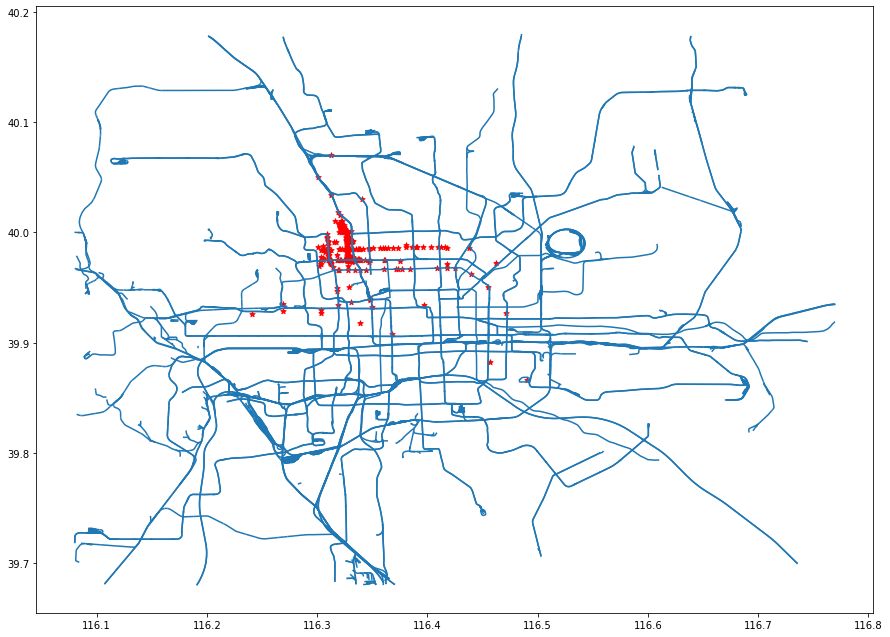

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame

beijing_map = gpd.read_file('/content/railways.shp')

fig,ax = plt.subplots(figsize = (15,15))
beijing_map.plot(ax = ax)

#long_lats = [
#             (116.321, 40.004),
#             (116.320, 40.007),
#             (116.576, 40.033)
#]

long_lats_cleaned = [(x, y) for x, y in long_lats if x > 116 and x < 116.8 and y > 39 and y < 40.2]
print(sorted(long_lats))

geometry = [Point(i) for i in long_lats_cleaned]
geo_df = gpd.GeoDataFrame(geometry = geometry)
g = geo_df.plot(ax = ax, markersize = 30, color = 'red',marker = '*',label = 'Beijing')
plt.show()

In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

df_30min = df_combine.filter((df_combine.Time.substr(4, 5).contains("00:00") | df_combine.Time.substr(4, 5).contains("30:00")))
df_30min = df_30min.filter((df_30min.Long.cast(DoubleType()) > 115) & (df_30min.Long.cast(DoubleType()) < 117))
df_30min = df_30min.filter((df_30min.Lat.cast(DoubleType()) > 39) & (df_30min.Lat.cast(DoubleType()) < 41)).cache()

print(df_30min.take(5))

vectorAssembler = VectorAssembler(inputCols=["Long", "Lat"], outputCol="features")
kmeans = KMeans().setK(30)
pipeline = Pipeline(stages=[vectorAssembler, kmeans])

model = pipeline.fit(df_30min)
#model = kmeans.fit(dataset)

centers = model.stages[1].clusterCenters()
print(centers)


[Row(Lat=40.004432, Long=116.321243, Alt=300, DayCount=39794.1875, Date=datetime.date(2008, 12, 12), Time='04:30:00', UserId='000'), Row(Lat=40.00737, Long=116.319546, Alt=155, DayCount=39766.6875, Date=datetime.date(2008, 11, 14), Time='16:30:00', UserId='000'), Row(Lat=40.033158, Long=116.575582, Alt=77, DayCount=39909.1458333333, Date=datetime.date(2009, 4, 6), Time='03:30:00', UserId='000'), Row(Lat=40.080045, Long=116.588057, Alt=30, DayCount=39909.1875, Date=datetime.date(2009, 4, 6), Time='04:30:00', UserId='000'), Row(Lat=39.971705, Long=116.462737, Alt=152, DayCount=39909.2083333333, Date=datetime.date(2009, 4, 6), Time='05:00:00', UserId='000')]
[array([116.46581001,  39.92542773]), array([116.31165103,  40.05207792]), array([115.77725593,  39.8558898 ]), array([116.26189869,  39.86912475]), array([115.70253833,  39.11580891]), array([116.74288383,  40.57890815]), array([116.80455068,  39.97668137]), array([116.61096757,  40.30064513]), array([116.37410701,  39.97717277]), ar

[(116.46581000630714, 39.92542772921119), (116.31165102992134, 40.052077916206834), (115.77725592592594, 39.855889803703704), (116.26189868806073, 39.86912475412703), (115.70253832666681, 39.115808913333346), (116.74288383333332, 40.57890814696969), (116.80455068390803, 39.976681366666654), (116.610967571831, 40.3006451314554), (116.3741070124857, 39.97717276597638), (116.27880458988095, 40.20095735416665), (115.83671075666666, 40.36762565666667), (116.32302800237562, 39.98552323545869), (116.56999392899392, 40.07978090610776), (116.4331199825542, 39.978984304942855), (116.0886873378948, 39.93151063824561), (116.3800039299355, 39.88268781854481), (116.99270899999999, 39.188862888888906), (116.71386791333333, 39.475861665000004), (116.32939354239902, 39.92690958569433), (116.08593783603602, 39.730245460360365), (116.48192643409209, 39.8519845018528), (116.8815411730159, 40.38274504999999), (116.33034647884615, 39.71639947692308), (116.59820381666667, 39.679362389999994), (116.6241176161

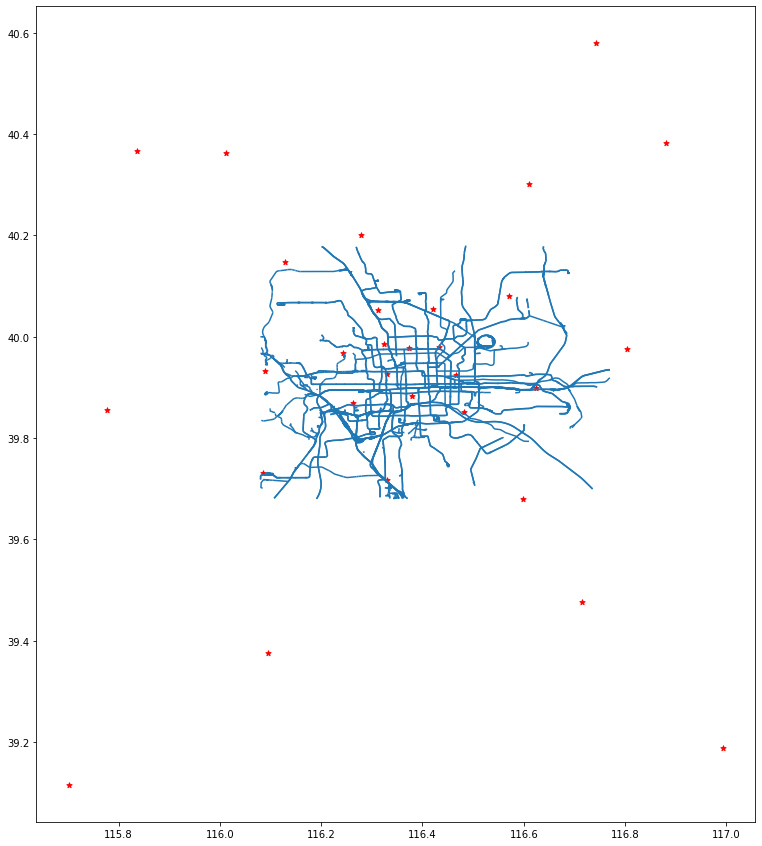

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame

beijing_map = gpd.read_file('/content/railways.shp')

fig,ax = plt.subplots(figsize = (15,15))
beijing_map.plot(ax = ax)

#long_lats = [
#             (116.321, 40.004),
#             (116.320, 40.007),
#             (116.576, 40.033)
#]

#long_lats_cleaned = [(x, y) for x, y in long_lats if x > 116 and x < 116.8 and y > 39 and y < 40.2]
#print(sorted(long_lats))

long_lats_kmeans_all = [(center[0], center[1]) for center in centers]
#long_lats_kmeans = [[(x, y) for x, y in long_lats_kmeans_all if x > 114 and x < 118 and y > 38 and y < 41]]
#long_lats_kmeans_all = [(116.3718359150295, 39.961173602508005), (91.67943257142856, 31.91393410714285), (116.76405412031248, 34.330193590104166), (109.71097196874999, 18.802368615624996), (123.98690892307692, 42.38542284615386), (102.585242, 36.72503021212121), (108.41767760299628, 22.862715707865163), (115.05558733333338, 28.085100641025644), (121.35821331173703, 31.160341288262906), (113.31208679908697, 37.69928435119048), (86.64344829166666, 42.504526625), (97.6189412682927, 37.94366214634146), (94.046294625, 35.692848291666664), (118.64795169512198, 39.79155769308942), (101.7315437, 25.878270049999998), (116.49337509956706, 36.91924595844155), (108.78992655652175, 34.43060047391304), (121.39656798974362, 39.39913228974359), (114.25980345806451, 22.998846099999994), (120.2028323097561, 31.792477509756104), (116.16617181818182, 25.619035757575762), (126.44590819999992, 44.520776033333334), (124.93783699999997, 46.618965942857145), (117.5033850618279, 32.21768480913978), (104.92648673076924, 31.176505969230767), (125.9890022, 41.69855806666666), (114.34868620211643, 30.78997277989418), (119.67593714285715, 33.87724771428571), (113.29360828104679, 34.75369177390605), (118.05591661428572, 30.378324897619045)]
long_lats_kmeans = long_lats_kmeans_all
print(long_lats_kmeans)

geometry_kmeans = [Point(i) for i in long_lats_kmeans]
geo_df = gpd.GeoDataFrame(geometry = geometry_kmeans)
g = geo_df.plot(ax = ax, markersize = 30, color = 'red',marker = '*',label = 'Beijing')
plt.show()

Average speed

In [6]:
from pyspark.sql.window import Window
from haversine import haversine
import pandas as pd
from pyspark.sql.functions import pandas_udf

from datetime import datetime, date, time
import pyspark.sql.functions as F

@pandas_udf("double")
def haversine_udf(lat: pd.Series, lon: pd.Series) -> float:
    if len(lat.tolist()) == 2:
      return haversine((lat.tolist()[0], lon.to_list()[0]), 
                       (lat.to_list()[1], lon.to_list()[1]))
    else:
      return -1

@pandas_udf("double")
def diffce_udf(times: pd.Series) -> float:
  if len(times.tolist()) == 2:
      time1 = time.fromisoformat(times.tolist()[1])
      time0 = time.fromisoformat(times.to_list()[0])
      return (datetime.combine(date.min, time1) - datetime.combine(date.min, time0)).total_seconds()/3600
  else:
      return -1

w = Window.partitionBy("UserId", "Date").orderBy("Time").rowsBetween(-1, 0)

df_speed = df_combine.withColumn("distance", haversine_udf("Lat", "Long").over(w)) \
            .withColumn("elapsed_time", diffce_udf("Time").over(w)) \
            .withColumn("speed", F.col("distance")/F.col("elapsed_time")) \
            .filter(F.col("distance") != -1).cache()

print(df_speed.take(5))

[Row(Lat=39.903464, Long=116.386052, Alt=492, DayCount=39832.0200578704, Date=datetime.date(2009, 1, 19), Time='00:28:53', UserId='002', distance=0.08480874869435938, elapsed_time=0.0005555555555555556, speed=152.6557476498469), Row(Lat=39.903335, Long=116.386271, Alt=491, DayCount=39832.0200694444, Date=datetime.date(2009, 1, 19), Time='00:28:54', UserId='002', distance=0.0235527034189274, elapsed_time=0.0002777777777777778, speed=84.78973230813864), Row(Lat=39.903173, Long=116.386498, Alt=491, DayCount=39832.0200810185, Date=datetime.date(2009, 1, 19), Time='00:28:55', UserId='002', distance=0.026446697240916233, elapsed_time=0.0002777777777777778, speed=95.20811006729843), Row(Lat=39.903118, Long=116.38654, Alt=491, DayCount=39832.0201041667, Date=datetime.date(2009, 1, 19), Time='00:28:57', UserId='002', distance=0.0070878411688112255, elapsed_time=0.0005555555555555556, speed=12.758114103860207), Row(Lat=39.903079, Long=116.386493, Alt=490, DayCount=39832.0201388889, Date=datetime

In [8]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import Evaluator

class MAPEEvaluator(Evaluator): # TODO: Fix class inheritance
  def __init__(self, predictionCol="prediction", labelCol="label"):
    self.predictionCol = predictionCol
    self.labelCol = labelCol

  def _evaluate(self, dataset):
    return evaluate(dataset, predictionCol, labelCol)

  def evaluate(dataset, predictionCol="prediction", labelCol="label"): # FIXME
    mapeDF = dataset.withColumn("ape", (F.col(predictionCol)-F.col(labelCol)) / F.col(labelCol))  \
      .groupBy().avg("ape").select("avg(ape)").withColumnRenamed("avg(ape)", "mape")
    r = mapeDF.collect()
    answer = [(row.mape) for row in r]
    return answer[0] * 100


print(df_speed.take(5))
df_speed = df_speed.filter(df_speed.Alt.isNotNull())

toPredict = "speed"

vectorAssembler = VectorAssembler(inputCols=["Alt"], outputCol="features")
regressor = LinearRegression(featuresCol='features', labelCol=toPredict)
pipeline = Pipeline(stages=[vectorAssembler, regressor])


inputTrainDF, inputTestDF = df_speed.randomSplit([0.8,0.2], seed=10)
print(inputTrainDF.take(5))
print(inputTestDF.take(5))

model = pipeline.fit(inputTrainDF)

predDF = model.transform(inputTestDF)

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=toPredict)

mae = evaluator.evaluate(predDF, {evaluator.metricName: "mae"})
rmse = evaluator.evaluate(predDF, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predDF, {evaluator.metricName: "r2"})
mape = MAPEEvaluator.evaluate(predDF, predictionCol="prediction", labelCol=toPredict)

print(f"answer2)-  {r2}, {mape}, {mae}, {rmse}")

[Row(Lat=39.903464, Long=116.386052, Alt=492, DayCount=39832.0200578704, Date=datetime.date(2009, 1, 19), Time='00:28:53', UserId='002', distance=0.08480874869435938, elapsed_time=0.0005555555555555556, speed=152.6557476498469), Row(Lat=39.903335, Long=116.386271, Alt=491, DayCount=39832.0200694444, Date=datetime.date(2009, 1, 19), Time='00:28:54', UserId='002', distance=0.0235527034189274, elapsed_time=0.0002777777777777778, speed=84.78973230813864), Row(Lat=39.903173, Long=116.386498, Alt=491, DayCount=39832.0200810185, Date=datetime.date(2009, 1, 19), Time='00:28:55', UserId='002', distance=0.026446697240916233, elapsed_time=0.0002777777777777778, speed=95.20811006729843), Row(Lat=39.903118, Long=116.38654, Alt=491, DayCount=39832.0201041667, Date=datetime.date(2009, 1, 19), Time='00:28:57', UserId='002', distance=0.0070878411688112255, elapsed_time=0.0005555555555555556, speed=12.758114103860207), Row(Lat=39.903079, Long=116.386493, Alt=490, DayCount=39832.0201388889, Date=datetime

Py4JJavaError: ignored